# 0. Project introduction

<blockquote> 

In this project we will analyze how the investment in R&D (Research and Development) by private business has an impact on GDP (Gross Domestic Product) of the Organisation for Economic Co-operation and Development (OECD) countries. We will get data from the World Bank and OECD Databases.<br>

We will visualize how private business investment in R&D has changed before (2005-2006), during (2007-2008), after (2009-2010) and 5 years after (2015) the economic crisis of 2007-2008.<br>

Special attention will be paid on the periods before, during and after the economic crisis. We are specially interested to see if the investment made by private business in R&D in the previous years of the economic crisis (2005-2006) have a positive impact on the countries GDP during the economic crisis (2007-2008) or after (2009-2010). In this case, we will expect that the higher the investment of private business in the previous years of the economic crisis, the lesser the impact on the GDP. <br>

1. We will import the files, keep the relevant columns and clean the data.
2. Normality assumptions will be tested based on graphs and statistical significance.
3. In case of non-normal distribution of the data, we will apply the appropriate data transformation for statistical analyses.
4. Correlation analysis will show us the associations between private business investment in R&D and countries GDP.
5. Regression analysis will allow us to see if the country GDP could be predicted by private business investment in R&D.

</blockquote>

# 1. Set up

## 1.1. Environment

<blockquote> 

We will import basic packages to manage data, as well as to perform statistical analyses and to visualize data <br> <b>Statistical packages:</b> Numpy, ScipyStats, Pinguoin and StatsModels <br> <b>Visualization packages:</b> Matplotlib, Seaborn and Missingno to visualize missing values

</blockquote>

In [67]:
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime as dt

## 1.2. Load data from previous notebook 

In [68]:
%store -r GDP_OECD
%store -r GERD_OECD
%store -r GDP_OECD_periods
%store -r GERD_OECD_periods
%store -r GERD_OECD_financed
%store -r GERD_OECD_performed

# 4. Data analysis

<blockquote>

For the data analysis process we will start with correlation analysis. As we have decided to use untransformed data, we will perform Spearman rank correlation. As we are exploring the data, we will perform two-tail correlations. If we were more confident about the data, and specific hypothesis were provided, one-tail correlations would have been performed.<br>

We will remove intra-dataframe variables (variables of the same dataframe, GERD or GDP) as we are most interested in the association between variables of both dataframes.<br>

1. We will create a dataframe merging data from the GDP and GERD of the same period.
2. We will create dataframes merging data from GDP and GERD from different periods:<br>
2.1. GERD before the economic crisis and GDP during the crisis.<br>
2.2. GERD during the economic crisis and GDP after the economic crisis.<br>
2.3. GERD after the economic crisis and GDP 5 years after the crisis.<br>
3. We will run the correlations using heatmaps to ease the visualization of the data. However we will also use statistics to check the statistical significant of the correlations.<br>

Finally, we will use quantile regression to predict the GDP based on the previous GERD involving private business. We chose quantile regression as it less affected by extreme values (outliers) and it allows to fit the regression line on different quantiles. However, as we have a small sample size, we will only compute the quantile regression on the median (quantile 0.5).

</blockquote>

## 4.1. Correlation analysis

### 4.1.1. Merge dataframes from the same time period

<blockquote>

GERD and GDP dataframes will be merged to perform correlation analysis from the same time period. We will perform an inner merge, keeping only the common values on country and time period columns. In case we find other common variable in both dataframes, we will add suffixes to differentiate them.
    
</blockquote>

In [69]:
GERD_GDP_periods = GERD_OECD_periods.merge(GDP_OECD_periods, how = 'inner', 
                                           on = ['LOCATION', 'Time period'], 
                                           suffixes = ('_GERD', '_GDP'))

display(GERD_GDP_periods.head())

,LOCATION,Time period,GERD_financed_business_perc,GERD_performed_business_perc,GERD_performed_business_perc_GDP,GDPV_ANNPCT,GDP_ANNPCT,PGDP
0,AUS,5 years after crisis,NaN,53.43116,1.025570,2.291594,1.639225,0.948468
1,AUS,after crisis,NaN,58.24648,1.356915,2.167884,5.096404,0.877910
2,AUS,before crisis,58.06899,58.03914,1.199850,2.910407,7.843265,0.748595
3,AUS,during crisis,61.90762,61.10159,1.426760,3.485093,9.098500,0.826548
4,AUT,5 years after crisis,49.73950,71.41998,2.178160,0.976060,3.291252,1.000000


### 4.1.2. Define functions to perform correlations analysis

<blockquote>

Two functions are defined to perform correlation analysis. The first returns a dataframe with correlation values. It removes intra-dataframe variables, as we are mainly interested in correlation between different dataframes. It allows to choose if the correlation should be one-tail or two-tail, method to compute correlations and add covariates if needed. We will take advantage of the GDP_vars and GERD_vars lists created to check normality assumption to use it in this function as it requires a list of variables to test.<br>

The second function returns a heatmap with correlation values in each cell. It ease the visualization of the associations between variables of both dataframes after merged.<br>

</blockquote>

In [70]:
periods = ['before crisis', 'during crisis', 'after crisis', '5 years after crisis']

def correlations(df, var_list, tail, correction, method, cov_list, *args):
    
    """
    Perform correlations for each time period defined,
    dropping intra task correlations in each time period. 
    Apply FDR correction for all uncorrected p-values.
    Joins everything in an unique df.
    FDR correction is applied for all uncorrected p-values of 
    each time period.
    
    Input:
    df: DataFame with all the data
    var_list: list of lists with variables for correlations
    tail: 'one-sided' or 'two-sided'
    correction: check statsmodels.multitest.multipletest for correction options
    method: 'pearson', 'spearman', etc. (check methods for pg.pairwise_corr)
    cov_list: list of covariables
    *args: strings to exclude intra task correlations from df and apply
           correction without these correlations
    
    Output:
    Dataframe with correlations statistics
    """
    
    list_of_dfs = []
    
    # perform correlation using pinguoin
    df_corr = pd.DataFrame(pg.pairwise_corr(df, columns = var_list,\
                       covar = cov_list, tail = tail, method = method,\
                       nan_policy = 'pairwise')).round(5)
    
    # drop intra correlations. Reset index because of dropped rows to ease concatenation
    for df_vars in args:
    # drop rows that contains variables of the same df
        df_corr = df_corr[~((df_corr['X'].isin(df_vars)) & (df_corr['Y'].isin(df_vars)))].reset_index(drop = True)
    
    return df_corr

def heatmap_corr(df, method):
    
    """
    Draw heatmaps with correlation values for variables that belongs to
    the same period. We can choose the method to perform the correlations.
    It should be added as string.
    
    Return heatmap with Pearson correlation for each period
    
    Input:
    df: DataFrame
    method: correlation method as string
    """
    
    periods_corr = periods
    
    fig, ax = plt.subplots(2, 2, figsize = (20, 20), sharex = True, sharey = True) # sharex = True to share x axis in all heatmaps
    plt.rc('xtick', labelsize = 15) # set xtick customization
    plt.rc('ytick', labelsize = 15) #set ytick customization
    plt.rc('font', size = 15) # set fontype used in xlabel, ylabel and title
    
    for i in range(len(periods_corr)):
        
        corrmat = df[df['Time period'] == periods_corr[i]].corr(method)
        
        if i <= 1:
            sns.heatmap(corrmat, cbar = True, square = True, annot = True, 
                        fmt = '.2f', annot_kws = {'size': 15}, ax = ax[0, i])
            ax[0, i].set_title(periods_corr[i])
        
        elif i >= 2:
            new_i = i - 2
            sns.heatmap(corrmat, cbar = True, square = True, annot = True, 
                        fmt = '.2f', annot_kws = {'size': 15}, ax = ax[1, new_i])
            ax[1, new_i].set_title(periods_corr[i])

#### 4.1.2.1. Correlation analysis for data of the same time period (exploratory purposes)

<blockquote>
    
Correlation analysis performed using Spearman rank correlation on heatmaps but also we checking the statistical significantce of correlations, keeping only those with a p-value below 0.05. Statistical values are sorted by p-values starting from the lowest value.

When correlating data from the same time period, we find positive associations between PGDP and GERD data from business enterprise. However, negative relationships with GDPV and GDP annual growth are found. These relationships are stronger during the before economic crisis period, and weaken as we go through subsequent time periods. Yet, we cannot stablish a causal relationship between variables with correlation analysis, only a positive or negative association between them.

**Positive correlations:** 

* Positive associations are seen during the before crisis period and during the economic crisis between PGDP and GERD variables, with correlation coefficients above 0.21. When considering statistical significance (critical p-value = 0.05), the correlation between PGDP and the percentage of GERD financed by business enterprise is statistically significant (spearman rank = .38, p = 0.03) only in the time period before the economic recession.
* In the subsequent time periods, no positive associations reach statistical significance. After the economic recession, only the association with the percentage of GERD financed by business enterprise remain moderate, but without statistical significance.
* Finally, five years after the economic crisis, these associations are turned negative, without reaching statistical significance.



**Negative correlations:**

* Concerning negative correlations, GDPV and GDP annual growth seems to be negatively associated with the GERD performed and financed by business enterprise data, reaching in some cases a correlation coefficient above 0.5 and statistical significance (ps < 0.01) 
* During the economic recession, the same negative associations from the period before the economic crisis remain negative and statistically significant (ps < .003)
* After the economic crisis, some of this associations became positive. However, the correlation coefficients are mainly zero in most cases and without statistical significance.
* Five years after the economic recession, correlation coefficients returned to levels seen before the economic crisis, with correlation coefficients reaching a value of - 0.35. Yet, only the relationship between GDPV annual growth and the percentage of GERD financed by business enterprise is statistically significant (p = .04)


It would be interesting to explore the positive correlation between the PGPD and the GERD variables, as they go in the expected direction. Also, the decrease in the Spearman coefficient during and after the crisis could be a result of the economic impact on those years in the GDP and in the business enterprise. However, we would have expected to see approximately the same correlations 5 years after the economic crisis, but it seems that the impact of the crisis goes beyond 2015.

</blockquote>

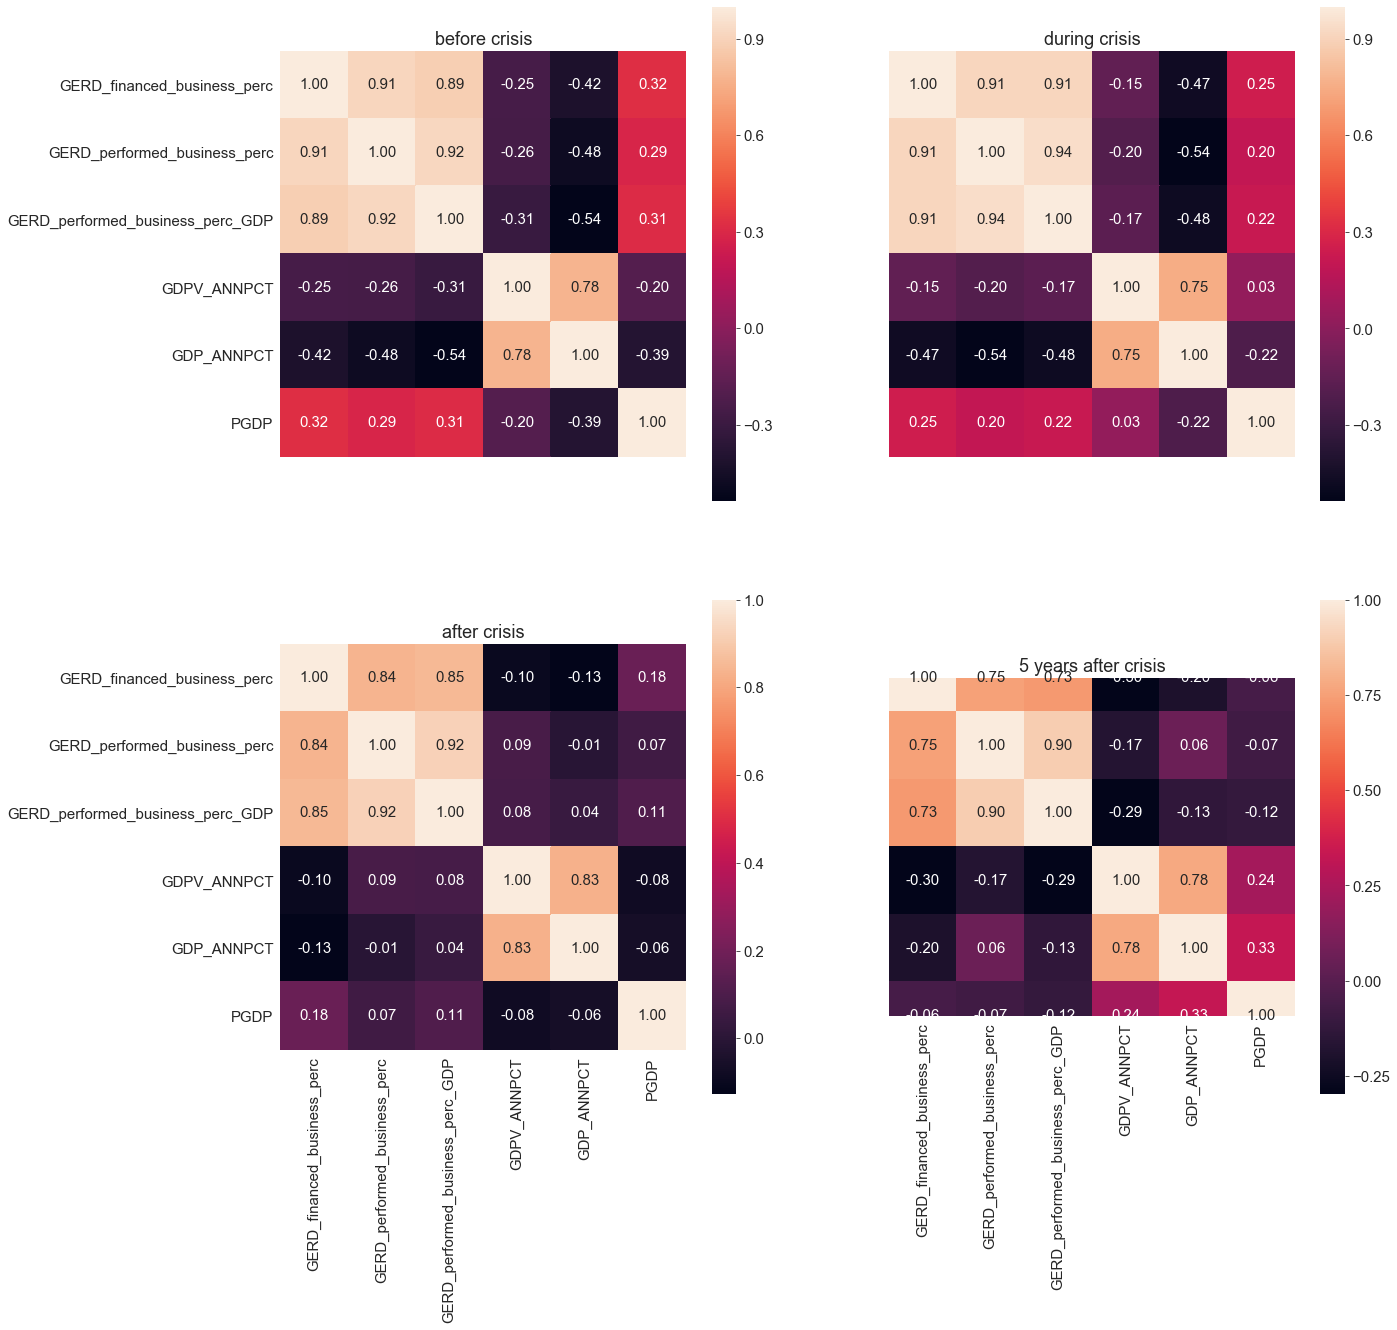

In [71]:
# heatmap
heatmap_corr(GERD_GDP_periods, 'spearman')

In [35]:
# correlations for the same time period. No covariates are included. 
# We avoid to correlate variables of the same df with each other

df_corr = []

for period in periods:
    
    df_Corr_GERD_GDP = correlations(GERD_GDP_periods[GERD_GDP_periods['Time period'] == period], 
                                    GERD_vars + GDP_vars , 'two-sided', '', 'spearman', [], GERD_vars, GDP_vars)
    df_Corr_GERD_GDP = df_Corr_GERD_GDP.loc[df_Corr_GERD_GDP['p-unc'] < .05].sort_values(by = 'p-unc')
    
    print('Correlation dataframe for time period: ' + str(period))
    
    display(df_Corr_GERD_GDP)

Correlation dataframe for time period: before crisis


,X,Y,method,covar,tail,n,r,CI95%,r2,adj_r2,z,p-unc,power
7,GERD_performed_business_perc_GDP,GDP_ANNPCT,spearman,[],two-sided,34,-0.54530,"[-0.75, -0.25]",0.29735,0.25202,-0.61167,0.00085,0.93159
4,GERD_performed_business_perc,GDP_ANNPCT,spearman,[],two-sided,34,-0.48113,"[-0.7, -0.17]",0.23149,0.18191,-0.52445,0.00397,0.84056
1,GERD_financed_business_perc,GDP_ANNPCT,spearman,[],two-sided,32,-0.40982,"[-0.66, -0.07]",0.16796,0.11057,-0.43540,0.01984,0.66137
2,GERD_financed_business_perc,PGDP,spearman,[],two-sided,32,0.38050,"[0.04, 0.64]",0.14478,0.08580,0.40064,0.03169,0.58960


Correlation dataframe for time period: during crisis


,X,Y,method,covar,tail,n,r,CI95%,r2,adj_r2,z,p-unc,power
4,GERD_performed_business_perc,GDP_ANNPCT,spearman,[],two-sided,36,-0.53771,"[-0.74, -0.25]",0.28913,0.24605,-0.60093,0.00072,0.93730
7,GERD_performed_business_perc_GDP,GDP_ANNPCT,spearman,[],two-sided,36,-0.50167,"[-0.71, -0.21]",0.25168,0.20632,-0.55154,0.00183,0.89359
1,GERD_financed_business_perc,GDP_ANNPCT,spearman,[],two-sided,34,-0.48419,"[-0.71, -0.17]",0.23444,0.18505,-0.52844,0.00371,0.84594


Correlation dataframe for time period: after crisis


,X,Y,method,covar,tail,n,r,CI95%,r2,adj_r2,z,p-unc,power


Correlation dataframe for time period: 5 years after crisis


,X,Y,method,covar,tail,n,r,CI95%,r2,adj_r2,z,p-unc,power
0,GERD_financed_business_perc,GDPV_ANNPCT,spearman,[],two-sided,34,-0.3482,"[-0.61, -0.01]",0.12125,0.06455,-0.3634,0.04358,0.53542


#### 4.1.2.2. Correlation analysis for data of different time period

<blockquote>
    
As we are interested in the prediction of a country GDP based on previous GERD involving private business, we will perform this correlation analyses between GERD variables in one period, and GDP variables of the inmediatly after time period.

**Summary:** 

**Positive correlations:** 

* No statistically significant association are found in the different correlation analysis:

* When correlating GERD data before the economic crisis and GDP during the economic recession, we find positive associations between PGDP and GERD data. However, none of them reach statistical significance. The highest correlation coefficient is found between PGDP and percentage of GERD financed by business enterprise (Spearman rank = 0.26)

* Positive associations are also seen when correlating GERD data during the economic recession and GDP after the economic crisis. The highest correlation coefficient is also found in the same correlation as in the previous period (Spearman rank = 0.31)

* Finally, when relating GERD data after the economic crisis and GDP data five years after, only the percentage of GERD financed by business enterprise is positively related to PGDP. However, as in previous cases, is not statistically significant.

**Negative correlations:**

* Only correlations between GERD data before the economic crisis and GDP data during the economic recession are found to be statistically significant. The highest correlation coefficients are found between GDP annual growth and GERD financed by business (Spearman rank = -0.41), GERD performed by business enterprise (Spearman rank = -0.49) and GERD performed by business enterprise as a percentage of GDP (Spearman rank = -0.48)
* When correlating data from GERD during the economic crisis and GDP after the economic recession, no statistically correlations are found. Also, the correlation coefficients become positive but remain small (Spearman rank < 0.19). None of them are significant.
* Negative correlations are found between GERD data after the economic crisis and GDP data five years after. The highest correlation coefficients are found between GDPV annual growth and GERD variables (Spearman rank between -0.28 and -0.14). None of them are significant.

</blockquote>

In [36]:
df1 = GERD_OECD_periods
df2 = GDP_OECD_periods
periods1 = ['before crisis', 'during crisis', 'after crisis']
periods2 = ['during crisis', 'after crisis', '5 years after crisis']

def heatmap_corr_periods(df1, df2, periods1, periods2, method):
    """
    Draw correlation heatmaps for variables of different
    time periods.
    
    Takes:
    df1: first dataframe
    df2: second dataframe
    periods1: list of time periods defined in a variable in df1
    periods2: list of time periods defined in a variable in df2
    
    Returns:
    
    Heatmaps and merged dataframe from different periods
    """
    dfs_return = []
    plt.rc('xtick', labelsize = 10) # set xtick customization
    plt.rc('ytick', labelsize = 10) #set ytick customization
    plt.rc('font', size = 10) # set fontype used in xlabel, ylabel and title
    plt.rc('figure', titlesize = 10)
    
    for period1, period2 in zip(periods1, periods2):
        
        df_f = df1[df1['Time period'] == period1].merge(df2[df2['Time period'] == period2], 
                                                        how = 'inner',
                                                        on = ['LOCATION'])
        dfs_return.append(df_f)
        
        fig, ax = plt.subplots(1, 1, figsize = (7, 7))
        corrmat = df_f.corr(method)
        sns.heatmap(corrmat, cbar = True, square = True, annot = True, fmt = '.2f', annot_kws = {'size': 10}, ax = ax)
        plt.title('Correlation between data ' + str(period1) + ' and ' + str(period2), x = 0.5, y = 1.1)
    
    return dfs_return

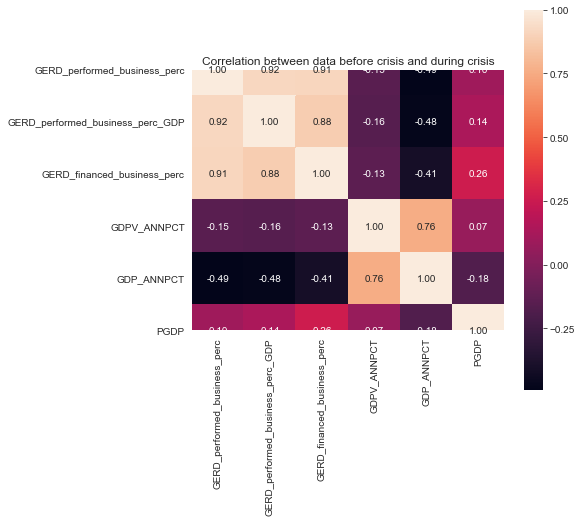

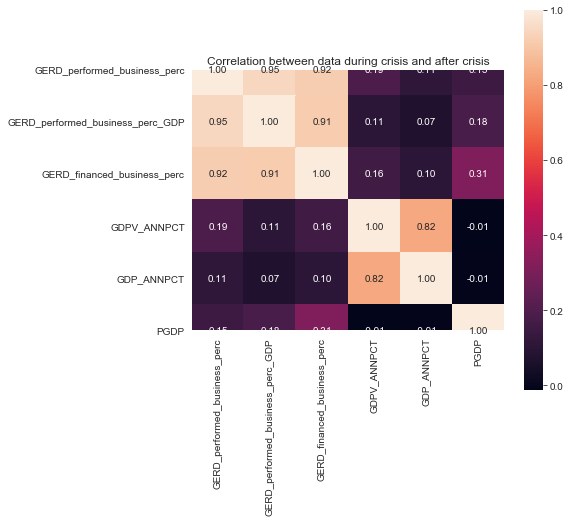

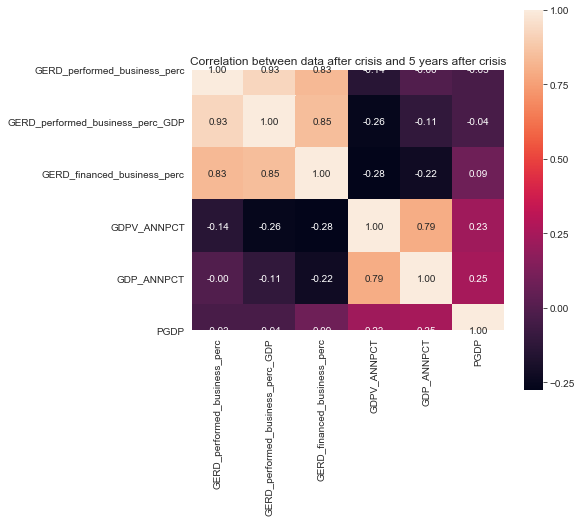

In [489]:
GERD_before_GDP_during_OECD, GERD_during_GDP_after_OECD, GERD_after_GDP_5years_OECD = heatmap_corr_periods(df1, df2, periods1, periods2, 'spearman')

In [490]:
dict_dfdiffperiods = {'GERD before and GDP during crisis': GERD_before_GDP_during_OECD, 
                      'GERD during and GDP after crisis': GERD_during_GDP_after_OECD, 
                      'GERD after and GDP 5 years after crisis': GERD_after_GDP_5years_OECD}

for df_diffperiods_name, df_diffperiods in dict_dfdiffperiods.items():
    
    df_corr_diffperiods = correlations(df_diffperiods, 
                                       GERD_vars + GDP_vars , 
                                       'two-sided', 
                                       'fdr_bh', 
                                       'spearman', 
                                       [], 
                                       GERD_vars, GDP_vars)
    
    df_corr_diffperiods = df_corr_diffperiods.loc[df_corr_diffperiods['p-unc'] < .05].sort_values(by = 'p-unc')
    
    print('Showing correlation results for DataFrame: ' + str(df_diffperiods_name))
    
    display(df_corr_diffperiods)

Showing correlation results for DataFrame: GERD before and GDP during crisis


,X,Y,method,covar,tail,n,r,CI95%,r2,adj_r2,z,p-unc,power
4,GERD_performed_business_perc,GDP_ANNPCT,spearman,[],two-sided,34,-0.49335,"[-0.71, -0.19]",0.24340,0.19458,-0.54048,0.00303,0.86149
7,GERD_performed_business_perc_GDP,GDP_ANNPCT,spearman,[],two-sided,34,-0.47594,"[-0.7, -0.16]",0.22651,0.17661,-0.51772,0.00444,0.83117
1,GERD_financed_business_perc,GDP_ANNPCT,spearman,[],two-sided,32,-0.41019,"[-0.66, -0.07]",0.16826,0.11089,-0.43584,0.01971,0.66225


Showing correlation results for DataFrame: GERD during and GDP after crisis


,X,Y,method,covar,tail,n,r,CI95%,r2,adj_r2,z,p-unc,power


Showing correlation results for DataFrame: GERD after and GDP 5 years after crisis


,X,Y,method,covar,tail,n,r,CI95%,r2,adj_r2,z,p-unc,power


### 4.1.2. Define function for quantile regression and simple linear regression

<blockquote>

Quantile regression is more robust to the presence of outliers and it also allows to fit a regression model based on percentiles of the data. This method will be suitable if we expect to see different patterns predicted based on countries that are high or low in the percentile spectrum. However, as we don't have that many observations, we will only fit the regression line based on the median (percentile 0.5) instead of the mean which is more sensitive to extreme values.

</blockquote>

In [301]:
def quantileReg(df, predictor, dv, quantiles, xlabel, ylabel, plot_title):
    
    """
    Performs quantile regression fitting a regression
    line for each percentile.
    
    Input:
    df: DataFrame
    predictor: variable selected as predictor
    dv: predicted variable
    quantiles: list of quantiles as float numbers
    xlabel: string for the xlabel
    ylabel: string for the ylabel
    
    Output:
    Coefficients of the quantile regression and plot with
    a fitted regression line for each quantile
    """
    
    plt.rc('font', size = 11) # set fontype used in xlabel, ylabel and title
    plt.rc('figure', titlesize = 5)
    
    model = smf.quantreg(dv + "~" + predictor, df)
    quantiles = quantiles
    fits = [model.fit(q = q) for q in quantiles]
    print(fits[0].summary())
    #print(fits[1].summary())
    #print(fits[2].summary())

    figure, axes = plt.subplots(figsize = (7, 7))
    x = df[predictor]
    y = df[dv]
    axes.scatter(x, df[dv], c = "black", alpha = 0.7)
    fit = np.polyfit(x, y, deg=1)
    _x = np.linspace(x.min(), x.max())
    for index, quantile in enumerate(quantiles):
        _y = fits[index].params[predictor] * _x + fits[index].params["Intercept"]
        axes.plot(_x, _y, label = quantile)

    plt.title(plot_title)
    axes.legend()
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    
def simpleReg(df, predictor, dv, predictor_name, dv_name, title):
    
    """
    Perform simple linear regression, plot residuals and
    plot regression line
    
    Input:
    df: DataFrame
    predictor: predictor variable as string
    dv: dependent variable as string
    predictor_name: name of the predictor variable as string
    dv_name: dependent variable name as string
    title: plot title as string
    
    Output:
    Regression coefficients
    Residuals plot
    Simple Linear Regression plot
    """
    
    # set params
    plt.rc('font', size = 11) # set fontype used in xlabel, ylabel and title
    plt.rc('figure', titlesize = 5)
    
    # simple linear regression
    lm = pg.linear_regression(df[predictor], 
                              df[dv], 
                              add_intercept = True, 
                              remove_na = True)
    # plot residuals
    stats.probplot(lm.residuals_, plot = plt)
    
    # plot regression line
    fig, ax = plt.subplots()
    fig.set_size_inches(7,7)
    sns.regplot(predictor, dv, data = df, color = 'k', marker = 'o', ax = ax)
    ax.set_xlabel(predictor_name)
    ax.set_ylabel(dv_name)
    ax.set_xticklabels(['{:.0f}'.format(float(x)) for x in ax.get_xticks().tolist()])
    ax.tick_params(axis = 'both', which = 'major')
    plt.title(title)
    
    return lm

#### 4.1.2.1. Regression

<blockquote>

As we are interested in the capacity of GERD data to predict the GDP, we will focus the regression analysis in those significant correlations found between different time periods. As stated before, significant correlations were only found between the GERD data before the economic crisis and GDP data during the economic recession.

**Summary quantile regression:** in the first case we can note that the percentage of GERD performed by business enterprise before the economic crisis is a significant predictor of GDP annual growth during the economic recession for the median (p = 0.01). We can see that our intercept for this model is 14.46, and the slope for our predictor -0.15. This means that for one unit of increase in the GERD financed by business enterprise, GDP annual growth during the recession period decreases 0.15. We can also see that the pseudo R-squared has a value of 0.12, explaining the model a 12% of the variance in the predicted variable.<br>

One problem that we face with quantile regression is that it is more appropriate to use it with a large sample size. As in our case we have a small sample size (n = 37), we will perform simple linear regression and check if the residuals are normally distributed.<br>

**Summary simple linear regression:** we can see residuals in the simple linear regression model are not normally distributed. However, the model returned a significant p-value for the predictor (p < 0.001). The intercept, 15.01, is quite close to the one computed by quantile regression, as well as the slope -0.14.

</blockquote>

                         QuantReg Regression Results                          
Dep. Variable:             GDP_ANNPCT   Pseudo R-squared:               0.1250
Model:                       QuantReg   Bandwidth:                       5.789
Method:                 Least Squares   Sparsity:                        10.94
Date:                Sat, 05 Sep 2020   No. Observations:                   32
Time:                        17:39:34   Df Residuals:                       30
                                        Df Model:                            1
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       14.4671      3.372      4.290      0.000       7.580      21.354
GERD_performed_business_perc    -0.1522      0.058     -2.602      0.014      -0.272      -0.033


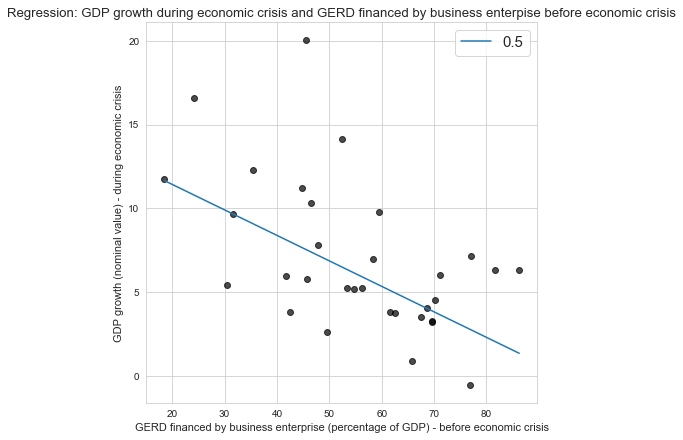

In [491]:
# as we have NaN values in the GERD financed by business enterprise variables, we will drop NaN in the regression model.

quantileReg(GERD_before_GDP_during_OECD.dropna(), 'GERD_performed_business_perc', 'GDP_ANNPCT', [0.5], 
            'GERD financed by business enterprise (percentage of GDP) - before economic crisis', 
            'GDP growth (nominal value) - during economic crisis',
            'Regression: GDP growth during economic crisis and GERD financed by business enterpise before economic crisis')

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,15.012301,2.263516,6.632294,1.763413e-07,0.303002,0.281221,10.401670,19.622931
1,GERD_performed_business_perc,-0.145397,0.038983,-3.729767,7.433993e-04,0.303002,0.281221,-0.224803,-0.065992


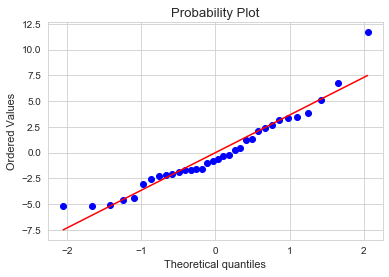

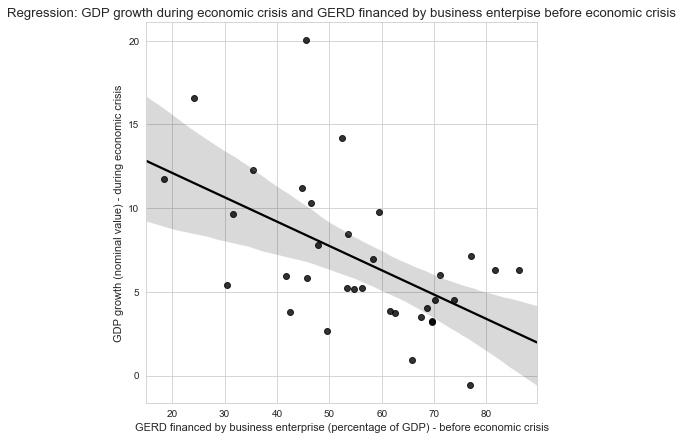

In [492]:
simpleReg(GERD_before_GDP_during_OECD, 'GERD_performed_business_perc', 'GDP_ANNPCT', 
          'GERD financed by business enterprise (percentage of GDP) - before economic crisis', 
          'GDP growth (nominal value) - during economic crisis',
          'Regression: GDP growth during economic crisis and GERD financed by business enterpise before economic crisis')

<blockquote>

**Summary quantile regression:** for the GDP annual growth during the economic crisis the GERD performed by business enterprise as a pecentage of GDP is not a significant predictor as revealed by quantile regression (p = .07). In this model we find an intercept of 8.20, and a slope of -2.22.The pseudo R-squared has a value of 0.04, explaining the model a 4% of the variance in the predicted variable.<br>

**Summary simple linear regression:** the simple linear regression model indicated that in this case that the GERD performed by business enterprise is a significant predictor (p = 0.01). However, the residuals are not normally distributed. The intercept is also quite close to the one in the quantile regression, 9.27, as well as the slope -2.26.

</blockquote>

                         QuantReg Regression Results                          
Dep. Variable:             GDP_ANNPCT   Pseudo R-squared:              0.04385
Model:                       QuantReg   Bandwidth:                       6.107
Method:                 Least Squares   Sparsity:                        11.21
Date:                Sat, 05 Sep 2020   No. Observations:                   34
Time:                        17:39:47   Df Residuals:                       32
                                        Df Model:                            1
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            8.2081      1.557      5.273      0.000       5.037      11.379
GERD_performed_business_perc_GDP    -2.2217      1.175     -1.891      0.068      -4.615       0.171


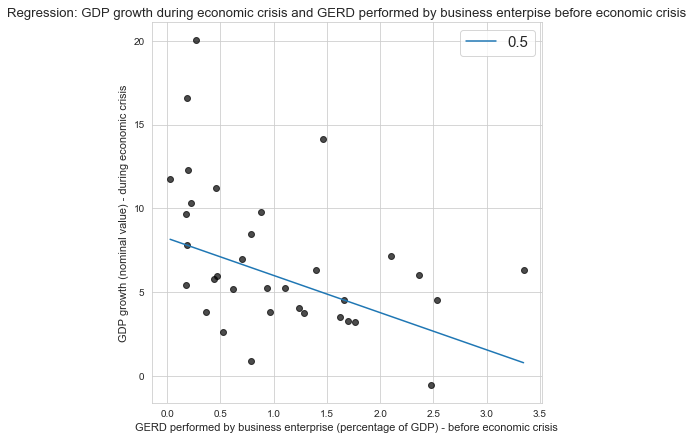

In [493]:
quantileReg(GERD_before_GDP_during_OECD, 'GERD_performed_business_perc_GDP', 'GDP_ANNPCT', [0.5],
            'GERD performed by business enterprise (percentage of GDP) - before economic crisis', 
            'GDP growth (nominal value) - during economic crisis',
            'Regression: GDP growth during economic crisis and GERD performed by business enterpise before economic crisis')

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,9.269155,1.116719,8.300345,1.751840e-09,0.183793,0.158287,6.994472,11.543837
1,GERD_performed_business_perc_GDP,-2.262277,0.842764,-2.684354,1.141343e-02,0.183793,0.158287,-3.978931,-0.545623


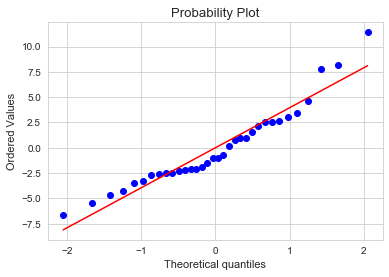

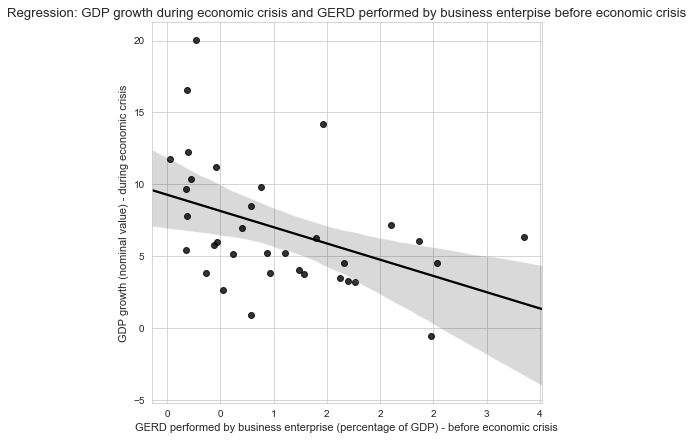

In [494]:
simpleReg(GERD_before_GDP_during_OECD, 'GERD_performed_business_perc_GDP', 'GDP_ANNPCT', 
          'GERD performed by business enterprise (percentage of GDP) - before economic crisis', 
          'GDP growth (nominal value) - during economic crisis',
          'Regression: GDP growth during economic crisis and GERD performed by business enterpise before economic crisis')

<blockquote>

**Summary quantile regression:** finally, for the GDP annual growth during the economic crisis the percentaefe of GERD financed by business enterprise is a significant predictor as revealed by quantile regression (p = .01). In this model we find an intercept of 16.53 and a slope of -0.21The pseudo R-squared has a value of 0.07, explaining the model a 7% of the variance in the predicted variable.<br>

**Summary simple linear regression:** the simple linear regression model indicated that in this case that the GERD performed by business enterprise is a significant predictor (p = 0.006). However, the residuals are not normally distributed. The intercept is also quite close to the one in the quantile regression, 14.34, as well as the slope -0.15.

</blockquote>

                         QuantReg Regression Results                          
Dep. Variable:             GDP_ANNPCT   Pseudo R-squared:              0.07275
Model:                       QuantReg   Bandwidth:                       6.185
Method:                 Least Squares   Sparsity:                        11.96
Date:                Sat, 05 Sep 2020   No. Observations:                   32
Time:                        18:02:14   Df Residuals:                       30
                                        Df Model:                            1
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      16.5354      3.912      4.227      0.000       8.547      24.524
GERD_financed_business_perc    -0.2074      0.076     -2.721      0.011      -0.363      -0.052


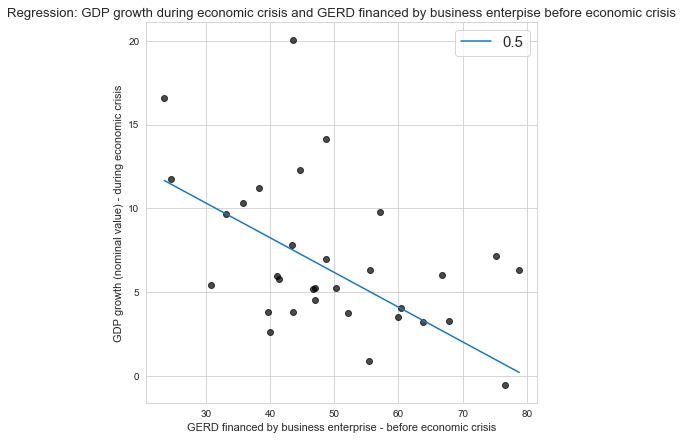

In [499]:
quantileReg(GERD_before_GDP_during_OECD.dropna(), 'GERD_financed_business_perc', 'GDP_ANNPCT', [0.5], 
            'GERD financed by business enterprise - before economic crisis', 
            'GDP growth (nominal value) - during economic crisis',
            'Regression: GDP growth during economic crisis and GERD financed by business enterpise before economic crisis')

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,14.347057,2.635863,5.443020,0.000007,0.221333,0.195377,8.963906,19.730208
1,GERD_financed_business_perc,-0.149980,0.051360,-2.920165,0.006582,0.221333,0.195377,-0.254872,-0.045089


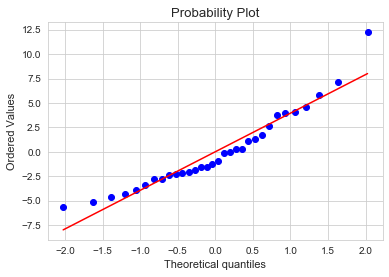

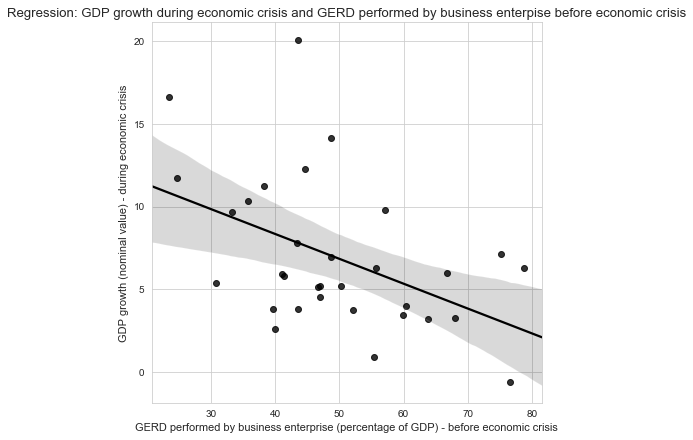

In [498]:
simpleReg(GERD_before_GDP_during_OECD.dropna(), 'GERD_financed_business_perc', 'GDP_ANNPCT', 
          'GERD performed by business enterprise (percentage of GDP) - before economic crisis', 
          'GDP growth (nominal value) - during economic crisis',
          'Regression: GDP growth during economic crisis and GERD performed by business enterpise before economic crisis')

# 5. Results

<blockquote>
    
**Correlations from the same time period**

The percentage of GERD financed by business enterprise is positively associated with the PGDP, but only before the economic crisis. No significant positive correlations are found in the rest of time periods, not even five years after the economic crisis.

The GDP annual growth is negatively correlated with GERD financed and performed by business enterprise, and this associations remain during the economic recession. After the economic crisis these correlations are lost, as it could be a period of economic readjustment. However, five years after the economic recession we found a negative correlation between GDPV annual growth and the percentage of GERD financed by business enterprise, possibly indicating the tendency of the data to come back to the same associations seen before the economic recession.

**Correlations from different time periods**

Only correlations between GERD data before the economic crisis and GDP data during the economic recession are found to be statistically significant. The highest correlation coefficients are found between GDP annual growth and GERD financed by business (Spearman rank = -0.41), GERD performed by business enterprise (Spearman rank = -0.49) and GERD performed by business enterprise as a percentage of GDP (Spearman rank = -0.48)

**Regression analysis**

We find that the percentage of the GERD performed by business enterprise is a significant predictor of the GDP annual growth, when entered in the regression model. In this case we will interpret the results of the quantile regression due to the not normally distributed residuals. For one unit of increase in the percentage of GERD performed by business enterprise, the GDP annual growth decreases by 0.15

The percentage of GERD performed by business enterprise as a percentage of GDP is also a significant predictor of GDP annual growth as indicated by simple linear regression, which predicts the mean of the dependent variable. However, when predicting the mean of the dependent variable, the predictor is not statistically significant. As we have not normally distributed residuals, we should be cautious to interpret this result. We should rely on the quantile regression results, as it predicts the median of the dependent variable, being less affected by extreme values.

Finally, the percentage of GERD financed by business enterprise is also a significant predictor of the GDP annual growth in both quantile and simple linear regression. In this case, an increase in one unit of the percentage of GERD financed by business enterprise, the GDP annual growth decreases by 0.20.

</blockquote>